# Model collaboration example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

In [2]:
def build_model(**params):
    
    # List of parameters
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=(92,5,), return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    return model

In [3]:
model1 = {'lstmsize': 178,
          'density': 164,
          'twice': True,
          'dropout': 0.1,
          'full_density': True,
          'activation': 'elu',
          'shuffle': True,
          'optimizer': 'adam'}

model2 = {'density': 222,
          'shuffle': True,
          'activation': 'relu',
          'twice': False,
          'lstmsize': 138,
          'optimizer': 'adam'}

model3 = {'density': 186,
          'activation': 'softsign',
          'twice': True,
          'full_density': True,
          'lstmsize': 158,
          'shuffle': True,
          'optimizer': 'adam'}

model4 = {'lstmsize': 118,
          'activation': 'relu',
          'optimizer': 'adam',
          'shuffle': True,
          'density': 98,
          'twice': False}

model5 = {'lstmsize': 178,
          'twice': True,
          'full_density': True,
          'density': 142,
          'dropout': 0.1,
          'optimizer': 'adam',
          'activation': 'softsign',
          'shuffle': True}

In [4]:
model1 = build_model(**model1)
model2 = build_model(**model2)
model3 = build_model(**model3)
model4 = build_model(**model4)
model5 = build_model(**model5)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model1.load_weights('./checkpoints/IBM_MSE/IBM.(best).hdf5')
model2.load_weights('./checkpoints/IBM_2days/IBM.(best).hdf5')
model3.load_weights('./checkpoints/IBM_3days/IBM.(best).hdf5')
model4.load_weights('./checkpoints/IBM_4days/IBM.(best).hdf5')
model5.load_weights('./checkpoints/IBM_5days/IBM.(best).hdf5')

##### I load the data and try to do some predictions over periods of 5 days usign the 5 previous models

In [6]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')
data = data.drop(columns='date')

# Sequence for the LSTM network
backlook = 92

# Normalise data
normaliser = preprocessing.MinMaxScaler()
data_norm = normaliser.fit_transform(data)

# Y raw data
next_day_open_values = np.array([data.to_numpy()[:,0][i + backlook] for i in range(len(data) - backlook)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

# Y normaliser
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit_transform(next_day_open_values)

array([[0.3303677 ],
       [0.32881229],
       [0.33814471],
       ...,
       [0.44689853],
       [0.43681951],
       [0.44279226]])

In [7]:
for i in np.arange(0,30,1):
    if i == 0:
        day1_sequence = np.array([data_norm[-(backlook+i):].copy()])
    else:
        day1_sequence = np.array([data_norm[-(backlook+i):-i].copy()])
        
    day2index = np.arange(len(data)+1-i-(backlook*2), len(data)-i, 2)
    day3index = np.arange(len(data)+2-i-(backlook*3), len(data)-i, 3)
    day4index = np.arange(len(data)+3-i-(backlook*4), len(data)-i, 4)
    day5index = np.arange(len(data)+4-i-(backlook*5), len(data)-i, 5)
    
    day2_sequence = np.array([data_norm[day2index].copy()])
    day3_sequence = np.array([data_norm[day3index].copy()])
    day4_sequence = np.array([data_norm[day4index].copy()])
    day5_sequence = np.array([data_norm[day5index].copy()])
    
    if i == 0:
        prediction = np.array([y_normaliser.inverse_transform(model1.predict(day1_sequence)),
                               y_normaliser.inverse_transform(model2.predict(day2_sequence)),
                               y_normaliser.inverse_transform(model3.predict(day3_sequence)),
                               y_normaliser.inverse_transform(model4.predict(day4_sequence)),
                               y_normaliser.inverse_transform(model5.predict(day5_sequence))]).reshape(1,5)
        
        test_data = np.array([data.to_numpy()[-5:,0]]).reshape(1,5)
        
    else:
        prediction = np.append(np.array([y_normaliser.inverse_transform(model1.predict(day1_sequence)),
                                         y_normaliser.inverse_transform(model2.predict(day2_sequence)),
                                         y_normaliser.inverse_transform(model3.predict(day3_sequence)),
                                         y_normaliser.inverse_transform(model4.predict(day4_sequence)),
                                         y_normaliser.inverse_transform(model5.predict(day5_sequence))]).reshape(1,5),
                               prediction, axis=0)
        
        test_data = np.append(np.array([data.to_numpy()[-5-i:-i,0]]).reshape(1,5), test_data, axis=0)

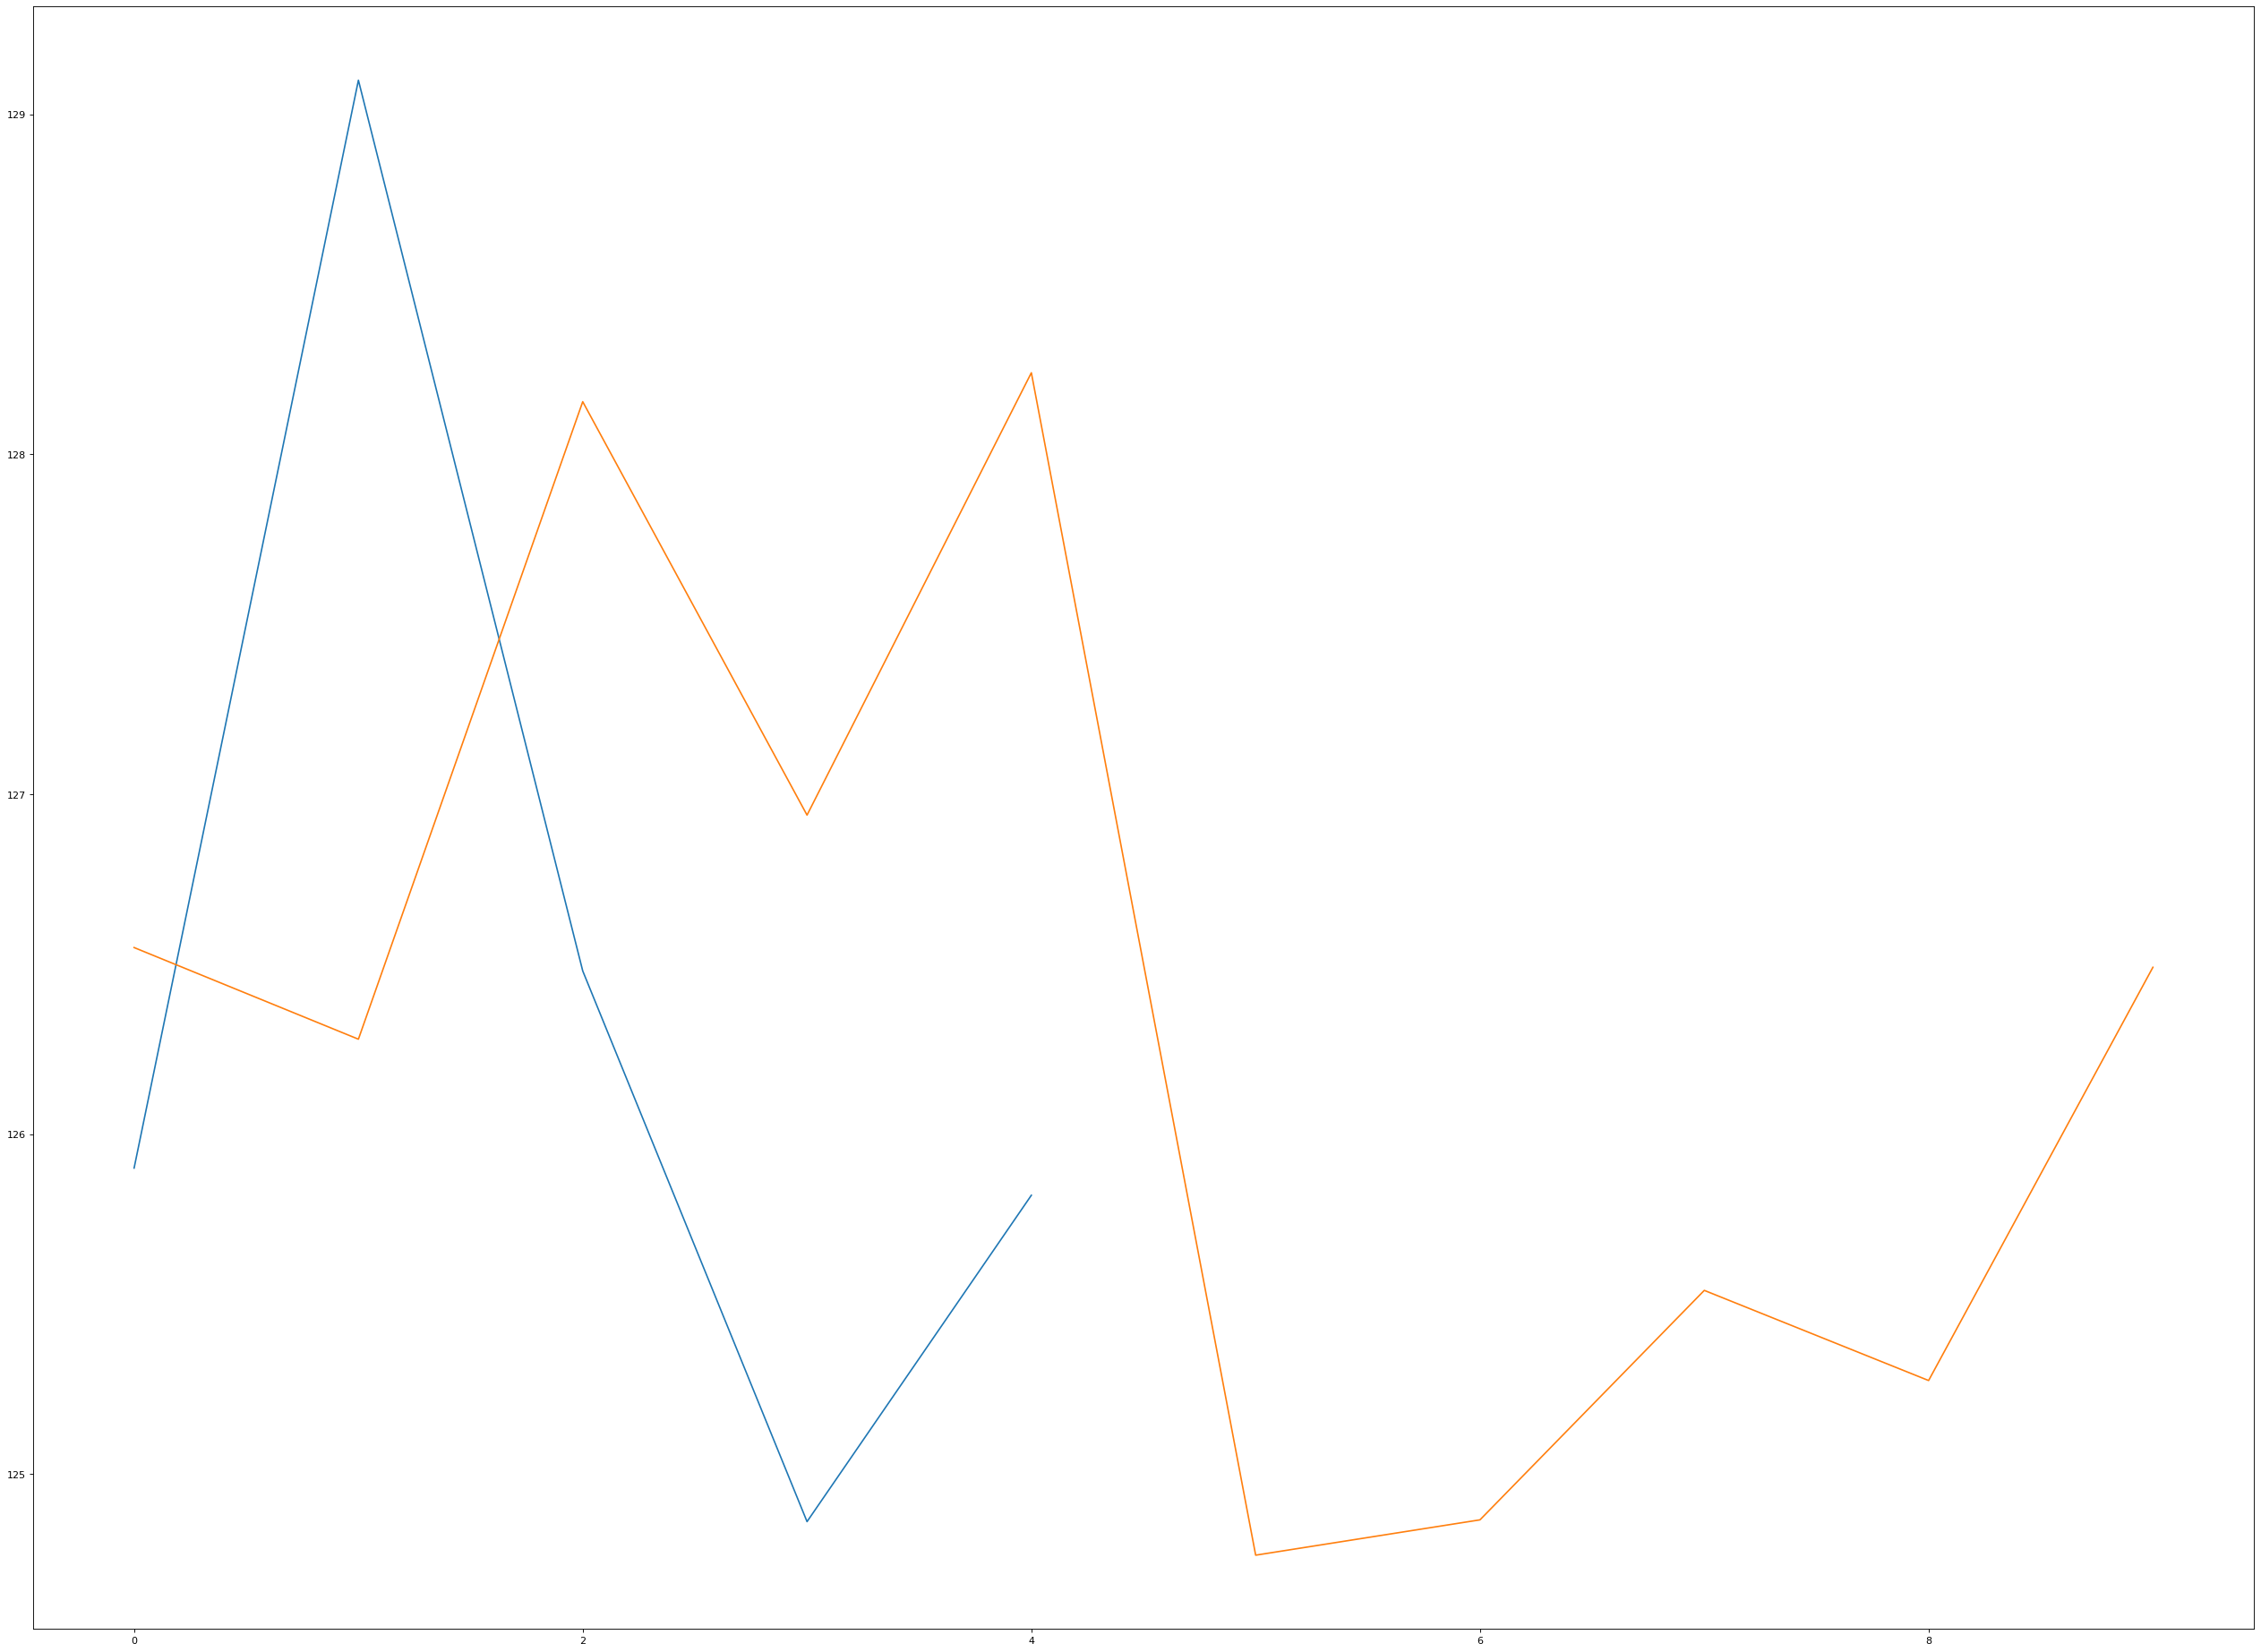

In [8]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(5), test_data[-1])
plt.plot(range(10), np.append(prediction[-6], prediction[-1]))
plt.show()

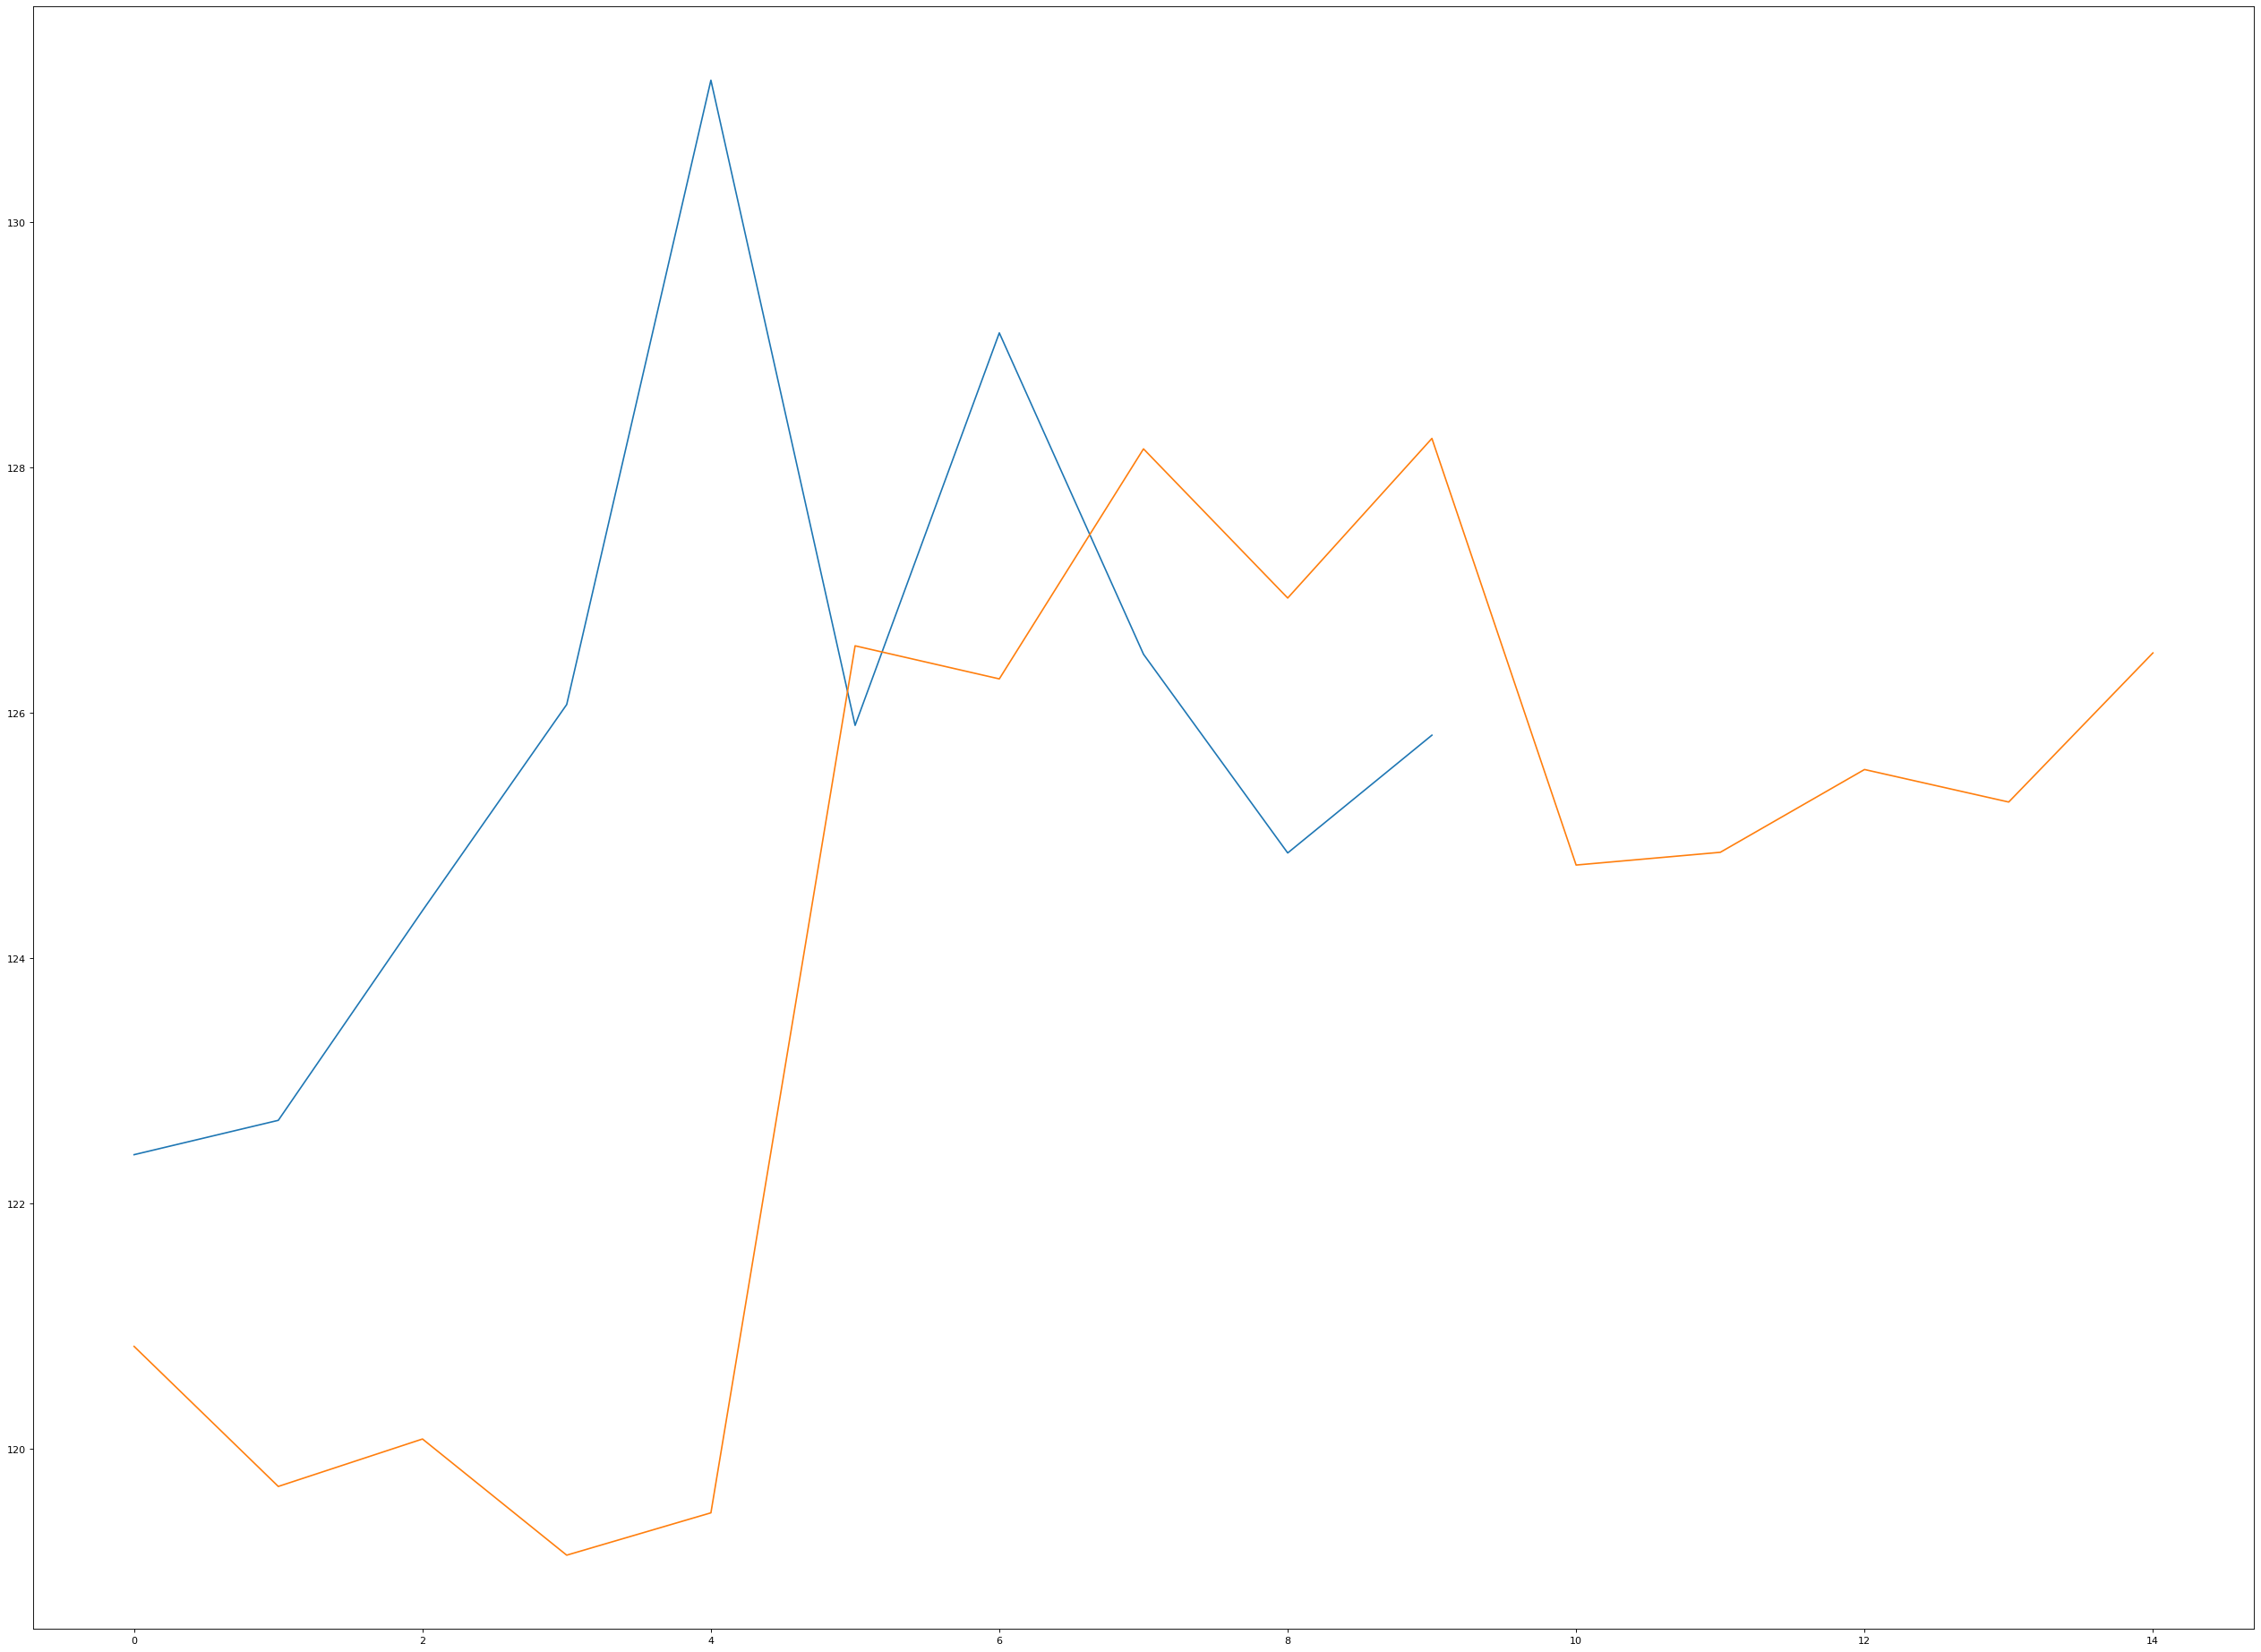

In [9]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(10), np.append(test_data[-6], test_data[-1]))
plt.plot(range(15), np.append(prediction[-11], np.append(prediction[-6], prediction[-1])))
plt.show()

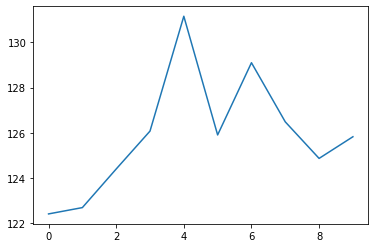

In [10]:
# Comprobación de que estoy recogiendo bien los datos

plt.plot(range(10), data.to_numpy()[-10:,0])
plt.show()